In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
tf.enable_eager_execution() # Session 그만좀 쓰자...
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

# \[ Tensorflow Probability \]
---

텐서플로우에서는 확률 이론을 다루기 위한 라이브러리를 별도로 구성하여 지원합니다. `tensorflow_probability`라고 불리는 이 라이브러리는 텐서플로우와 연동되면서, Bayesian Network에서 구현하기 어려웠던 여러 부분들을 쉽게 모듈화하였습니다.


````
The TensorFlow Distributions library implements a vision of probability theory adapted to the modern deeplearning paradigm of end-to-end differentiable computation
- Tensorflow Distributions
````

reference : https://arxiv.org/pdf/1711.10604.pdf


이번에는 TFP 중 분포를 다루는 `distributions`만을 집중적으로 다루어보도록 하겠습니다.

In [2]:
try:
    import tensorflow_probability as tfp
    import tensorflow_probability.python.distributions as tfd
except:
    !pip install tensorflow_probability
    import tensorflow_probability as tfp
    import tensorflow_probability.python.distributions as tfd

## 1. 분포 정의하기
---

아래와 같이 분포를 정의할 수 있습니다. 각 분포에 맞는 Parameter을 지정해주면, 우리는 분포 객체를 구성할 수 있습니다.

In [3]:
normal = tfd.Normal(loc=0., scale=.5) # scale == standard deviance

### 샘플링하기

In [4]:
normal.sample()

<tf.Tensor: id=22, shape=(), dtype=float32, numpy=0.15104908>

In [5]:
normal.sample(10) # 10개를 Sampling하고 싶으면 아래와 같이 할수 있습니다.

<tf.Tensor: id=47, shape=(10,), dtype=float32, numpy=
array([-0.25630572,  0.8551888 ,  0.05005733,  0.3338864 ,  0.695187  ,
        0.4510943 ,  0.3159778 ,  0.44178095, -0.61520827,  1.0259129 ],
      dtype=float32)>

In [6]:
normal.sample([2,5]) # Shape로 넣으면 Shape에 맞게 나옵니다.

<tf.Tensor: id=70, shape=(2, 5), dtype=float32, numpy=
array([[ 0.2674568 ,  0.04295176, -0.36313987,  0.02802053, -0.7064129 ],
       [ 0.53371394, -1.0188072 , -0.21590303, -1.2746348 , -0.52497447]],
      dtype=float32)>

### 확률값 가져오기

우리는 주어진 분포에서 특정 값($x=0$)에 대한 확률밀도함수 값($P(x=0)$)을 아래와 같이 구할 수 있습니다.

* 이산 분포라면 -> Probability Mass Function(PMF)
* 연속 분포라면 -> Probability Density Function(PDF)

정규분포의 확률밀도함수는 아래와 같습니다.

$$
Norm(x;\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}exp(-\frac{(x-\mu)^2}{2\sigma^2})
$$


In [7]:
print(f"Norm(x=0) = {normal.prob(0):.3f}")
print(f"Norm(x=0.5) = {normal.prob(.5):.3f}")
print(f"Norm(x=1.5) = {normal.prob(1.5):.3f}")

Norm(x=0) = 0.798
Norm(x=0.5) = 0.484
Norm(x=1.5) = 0.009


정규분포의 확률밀도함수를 Ploting하면 아래와 같습니다.

In [16]:
xs = np.linspace(-5,5,300)
ys = normal.prob(xs) # 각 값에 대응되는 확률밀도함수 값을 반환합니다.

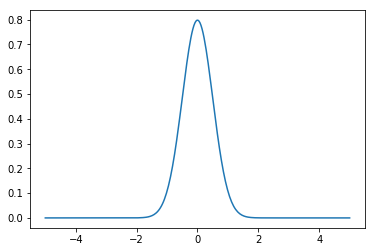

In [17]:
plt.plot(xs,ys)
plt.show()

### Momentum 구하기

In [18]:
mean = normal.mean()
var = normal.variance()
std = normal.stddev()
print(f"E[X] = {mean:.3f}")
print(f"Var[X] = {var:.3f}")
print(f"Std[X] = {std:.3f}")

E[X] = 0.000
Var[X] = 0.250
Std[X] = 0.500


### Entropy 구하기

확률분포가 가지는 Entropy도 쉽게 구할 수 있습니다.

$$
H(X) = -\int_{E} p(x)logp(x)dx
$$

In [26]:
normal.entropy()

<tf.Tensor: id=824, shape=(), dtype=float64, numpy=1.4189385332046727>

단순한 실험을 해보겟습니다. 평균이 바뀌면, Normal Distribution의 엔트로피가 바뀔까요? 바뀔리 없습니다.

In [27]:
means = np.linspace(0.1,1.5)
entropys = []
for mean in means:
    normal = tfd.Normal(loc=mean, scale=1.)
    entropys.append(normal.entropy())

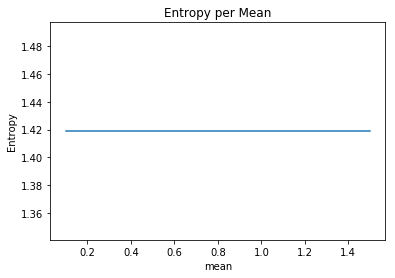

In [28]:
plt.title("Entropy per Mean")
plt.plot(means, entropys)
plt.xlabel('mean')
plt.ylabel('Entropy')
plt.show()

그렇다면 분산이 바뀌면 바뀔까요? 네, 분산이 커질수록 엔트로피도 커집니다.

In [29]:
scales = np.linspace(0.1,1.5)
normal = tfd.Normal(loc=0., scale=scales)
entropys = normal.entropy()

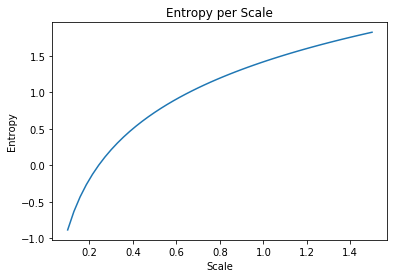

In [30]:
plt.title("Entropy per Scale")
plt.plot(scales, entropys)
plt.xlabel('Scale')
plt.ylabel('Entropy')
plt.show()

### KL Divergence 구하기



$$D_{KL}(P||Q) =\int p(x)log(\frac{p(x)}{q(x)})dx$$

In [31]:
P = tfd.Normal(loc=0., scale=.5)
Q = tfd.Normal(loc=0.5, scale=1.5)

In [32]:
P.kl_divergence(Q)

<tf.Tensor: id=1432, shape=(), dtype=float32, numpy=0.7097235>

KL Divergence 수식은 비 대칭으로, 두 값의 위치를 바꾸면 함수 값도 달라집니다. 아래를 통해 확인해보면 됩니다.

In [33]:
Q.kl_divergence(P)

<tf.Tensor: id=1448, shape=(), dtype=float32, numpy=3.4013877>

### Cross Entropy 구하기

두 분포에 대한 Cross Entropy($H(P,Q)$)는 아래와 같이 구할 수 있습니다.

$H(P,Q) = \int p(x)logq(x) dx$

In [34]:
P = tfd.Normal(loc=0., scale=.5)
Q = tfd.Normal(loc=0.5, scale=1.5)

두 분포에 대한 KL Divergence와 Cross Entropy, Entropy의 관계는 아래와 같습니다.

$$D_{KL}(P||Q) = H(P,Q) - H(P)$$
$$H(P,Q) = H(P) + D_{KL}(P||Q) $$



In [35]:
entropy_pq = P.cross_entropy(Q).numpy()
entropy_p = P.entropy().numpy()
kld_pq = P.kl_divergence(Q).numpy()

In [36]:
print(f"cross entropy(P,Q) : {entropy_pq:.3f}")
print(f"entropy(P) : {entropy_p:.3f}")
print(f"kld(P||Q) : {kld_pq:.3f}")

cross entropy(P,Q) : 1.436
entropy(P) : 0.726
kld(P||Q) : 0.710


### 복수 개의 변수에 대한 확률 분포 정의하기

우리는 복수 개의 변수에 대한 확률 분포도 아래와 같이 쉽게 정의할 수 있습니다. 우리는 변수 갯수만큼 Parameter를 지정해주면 됩니다.

In [37]:
nd = tfd.Normal(loc=[0.,1.],
                scale=[1.,2.])

In [38]:
nd.sample(10) # 각 분포에 대해 10개씩 반환합니다.

<tf.Tensor: id=1526, shape=(10, 2), dtype=float32, numpy=
array([[-3.2867318e-01,  2.7139888e+00],
       [ 1.8722377e+00,  3.7947345e+00],
       [ 8.4647465e-01,  4.7819271e+00],
       [ 2.7316606e-02, -6.5266144e-01],
       [ 1.9515076e+00,  3.8972249e+00],
       [ 4.3607750e-03, -1.1163671e+00],
       [-4.7072873e-01,  1.9653744e+00],
       [ 2.0242211e-01,  3.7119520e+00],
       [ 4.6498409e-01,  3.6198733e+00],
       [-1.4190254e+00,  9.5918477e-01]], dtype=float32)>

In [39]:
nd.prob([[0,.1]]) # 각 분포에 대한 PDF 값을 반환합니다.

<tf.Tensor: id=1539, shape=(1, 2), dtype=float32, numpy=array([[0.3989423 , 0.18026347]], dtype=float32)>

## 2. 다양한 분포 정의하기
---

### (1) 베르누이 분포 

베르누이의 확률질량함수(PMF)는 아래와 같습니다.

$$
Bern(x;\theta) = \begin{cases}
1-\theta, && \mbox{x = 0}\\
\theta && \mbox{x = 1}
\end{cases}
$$

베르누이 분포를 확률밀도함수로 표현하면 아래와 같습니다.<br>

In [40]:
bern = tfd.Bernoulli(probs=0.8)

In [41]:
print(f"x=0 일때의 확률 : {bern.prob(0):.2f}")
print(f"x=1 일때의 확률 : {bern.prob(1):.2f}")

W0824 23:00:31.292326 4601415104 deprecation.py:323] From /Users/ksj/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


x=0 일때의 확률 : 0.20
x=1 일때의 확률 : 0.80


베르누이 분포의 확률밀도함수를 시각화하면 아래와 같습니다.

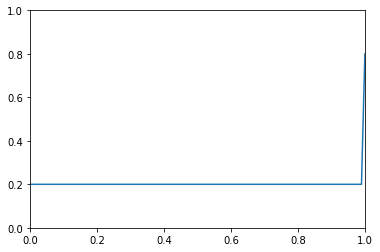

In [42]:
xs = np.linspace(0.,1.,100)
ys = bern.prob(xs).numpy()

plt.plot(xs,ys)
plt.xlim(0.,1.)
plt.ylim(0.,1.)
plt.show()

#### 샘플링하기

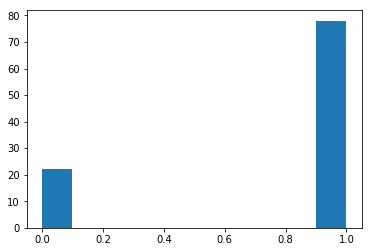

In [43]:
sampling = bern.sample(100)
plt.hist(sampling)
plt.show()

#### Momentum 구하기

In [44]:
mean = bern.mean()
var = bern.variance()
std = bern.stddev()
print(f"E[X] = {mean:.3f}")
print(f"Var[X] = {var:.3f}")
print(f"Std[X] = {std:.3f}")

E[X] = 0.800
Var[X] = 0.160
Std[X] = 0.400


#### KL Divergence 구하기

In [45]:
bern1 = tfd.Bernoulli(probs=0.8)
bern2 = tfd.Bernoulli(probs=0.3)

In [46]:
# 베르누이 분포끼리의 KL Divergence는 구할 수 있지만
bern1.kl_divergence(bern2)

<tf.Tensor: id=1662, shape=(), dtype=float32, numpy=0.5341108>

In [52]:
# 베르누이 분포와 가우시안 분포의 KL Divergence는 구할 수 없습니다.
bern1.kl_divergence(normal)

NotImplementedError: No KL(distribution_a || distribution_b) registered for distribution_a type Bernoulli and distribution_b type Normal

### (2) Categorical Distribution

Categorical Distribution은 베르누이 분포의 일반화된 형태입니다. Categorical 분포의  확률질량함수(PMF)는 아래와 같습니다.

$$
\textbf{p} = (p_1,...,p_k) \mbox{일 때,}\\
Cate(x;\textbf{P}) = P_x
$$

Categorical Distribution을 샘플링하면 아래와 같습니다.

In [53]:
cate = tfd.Categorical(probs=[0.3,0.2,0.5])

###  PMF 그리기

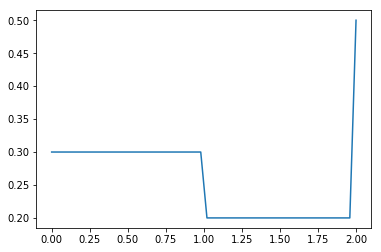

In [54]:
xs = np.linspace(0.,2.,)
ys = cate.prob(xs).numpy()

plt.plot(xs,ys)
plt.show()

#### 샘플링하기

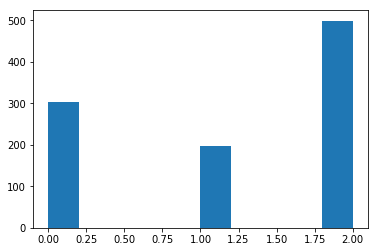

In [55]:
sampling = cate.sample(1000).numpy()

plt.hist(sampling)
plt.show()

## 3. 다변수 분포(Multivariate Distribution) 정의하기
---
다변수 분포는 아래와 같습니다.

In [56]:
nd = tfd.MultivariateNormalDiag(loc=[0., .5], 
                                scale_diag=[1., 2.])

In [57]:
nd.sample(10)

<tf.Tensor: id=1887, shape=(10, 2), dtype=float32, numpy=
array([[-1.6992414 , -2.2704625 ],
       [ 0.95967215,  3.6666102 ],
       [-2.1887503 , -0.23840815],
       [ 1.0409629 ,  0.5771738 ],
       [-1.0463585 ,  1.4051971 ],
       [ 0.4552363 , -0.4128052 ],
       [-0.33674318,  1.243989  ],
       [ 0.7726888 , -0.44113028],
       [-0.02556252,  1.584822  ],
       [-1.5042224 ,  1.2173636 ]], dtype=float32)>

위에서 정의한 2변수 분포$p(x_1,x_2)$는 `nd.prob`의 입력값으로 당연히, 각 변수에 대한 값이 필요합니다.

$p(x_1=0.,x_2=0.)$는 아래와 같이 구할 수 있습니다.

In [58]:
nd.prob([0,0])

<tf.Tensor: id=1949, shape=(), dtype=float32, numpy=0.07712913>

Multivarate Normal Distribution의 PDF 함수를 시각화해 보겠습니다.

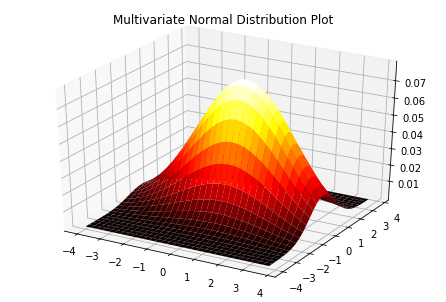

In [59]:
ys,xs = np.meshgrid(np.arange(-4,4,0.25),
                    np.arange(-4,4,0.25))

pts = np.stack([ys.ravel(),xs.ravel()],axis=1) 
zs = nd.prob(pts).numpy() # PDF 값 구하기

fig = plt.figure()
ax = Axes3D(fig)
ax.set_title("Multivariate Normal Distribution Plot")
ax.plot_surface(xs, ys, zs.reshape(ys.shape), 
                rstride=1, cstride=1, cmap='hot')
plt.show()

## 4. Mixture Distribution 구성하기
---

W0824 23:00:42.306845 4601415104 deprecation.py:323] From /Users/ksj/anaconda3/lib/python3.6/site-packages/tensorflow_probability/python/distributions/mixture.py:154: Categorical.event_size (from tensorflow_probability.python.distributions.categorical) is deprecated and will be removed after 2019-05-19.
Instructions for updating:
The `event_size` property is deprecated.  Use `num_categories` instead.  They have the same value, but `event_size` is misnamed.


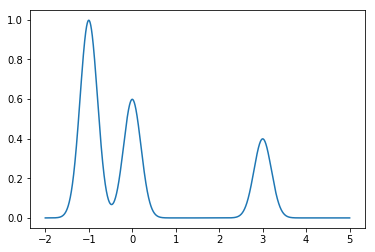

In [60]:
mix = 0.3
bimix_gauss = tfd.Mixture(
  cat=tfd.Categorical(probs=[0.5, 0.3, 0.2]),
  components=[
    tfd.Normal(loc=-1., scale=0.2),
    tfd.Normal(loc=0., scale=0.2),
    tfd.Normal(loc=3., scale=0.2),      
])

# Gaussian Mixture Distribution은 아래와 같이 구할 수 있습니다.
x = np.linspace(-2., 5., int(1e4))
z = bimix_gauss.prob(x).numpy()
plt.plot(x, z)
plt.show()